**Project Objective**

The objective of this project is to develop a machine learning model that can accurately estimate the AQI (Air Quality Index) given the input of a subset of pollutants and time data. This could drastically increase the deployment of AQI values, as these can be reported at an hourly rate. This model aims to be usable in real time to save resources and provide an accurate estimate of a given area's quality of air. is this good to put in my project?

In [25]:
import sklearn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot  as plt



station_hour = pd.read_csv("station_hour.csv")
stations = pd.read_csv("stations.csv")
station_day = pd.read_csv("station_day.csv")

print("Dataset shapes:")
print(f"station_hour: {station_hour.shape}")
print(f"stations: {stations.shape}")
print(f"station_day: {station_day.shape}")

station_hour.head()



C:\Users\Administrator\AppData\Local\Temp\ipykernel_14808\2826143872.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_hour = pd.read_csv("station_hour.csv")


Dataset shapes:
station_hour: (2589083, 16)
stations: (230, 5)
station_day: (108035, 16)


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,126.40,0.1,6.10,0.10,NaN,NaN
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,117.12,0.1,6.25,0.15,NaN,NaN
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,98.98,0.2,5.98,0.18,NaN,NaN
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,112.20,0.2,6.72,0.10,NaN,NaN
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,106.35,0.2,5.75,0.08,NaN,NaN


In [26]:
df_primary = station_hour.merge(
    stations,
    on='StationId',
    how='left',
    validate='m:1'
)

df_primary['AQI'].isna().sum()
df_primary['AQI_Bucket'].isna().sum()

570190

In [27]:
df_primary.tail()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,StationName,City,State,Status
2589078,WB013,2020-06-30 20:00:00,15.55,47.80,7.27,35.08,42.38,31.25,0.80,9.40,17.24,2.56,11.57,NaN,59.0,Satisfactory,"Victoria, Kolkata - WBPCB",Kolkata,West Bengal,Active
2589079,WB013,2020-06-30 21:00:00,15.23,42.30,6.10,26.78,32.85,30.66,0.56,4.91,17.46,3.49,12.29,NaN,59.0,Satisfactory,"Victoria, Kolkata - WBPCB",Kolkata,West Bengal,Active
2589080,WB013,2020-06-30 22:00:00,11.40,40.95,6.58,19.53,26.12,30.73,0.61,3.81,17.24,1.83,8.88,NaN,59.0,Satisfactory,"Victoria, Kolkata - WBPCB",Kolkata,West Bengal,Active
2589081,WB013,2020-06-30 23:00:00,9.25,34.33,9.17,21.85,31.00,29.61,0.65,3.44,12.74,1.40,8.43,NaN,59.0,Satisfactory,"Victoria, Kolkata - WBPCB",Kolkata,West Bengal,Active
2589082,WB013,2020-07-01 00:00:00,10.50,36.50,7.78,22.50,30.25,27.23,0.58,2.80,13.10,1.31,7.39,NaN,59.0,Satisfactory,"Victoria, Kolkata - WBPCB",Kolkata,West Bengal,Active


**Variable Information**

This dataset comprises information on the gases observed in the air and their corresponding dates of detection by the hour. Including the proportion of each gas, the name of the air quality monitoring station, the city where the recording was made, and the corresponding AQI (Air Quality Index) value. The dataset also includes information on the air quality monitoring stations themselves, including the city and state they reside in. The dataset consists largely of numeric features besides the dates (Datetime and Date) and an ordinal feature (AQI_Bucket) with categories: 0-50 'Good', 51-100 'Satisfactory', 101-200 'Moderate', 201-300 'Poor', 301-400 'Very Poor', 401+ 'Severe'". AQI_Bucket is directly determined by the value of AQI, meaning these two values are going to be strongly positively correlated with each other, and one should be removed to improve the quality of the model. This data will be split up into 70% training data, 5% validation data, and 25% test data to avoid data leakage. Finally, I will apply specific feature engineering, including cyclical encoding for time series data, seasonal information, rush hour variables, and splitting the datetime variable into its own respective variables for better specificity.



**Data Cleaning Process**
To capture the fluctuations of pollution each day, I will use the hourly data as the features for this supervised learning task, classifying into the respective AQI_Bucket values (Multi-class problem). I am not going to include the city_hour, city_day datasets, which include colluding aggregate data not on the same scale as the station data, and miss the variation of air pollution within each city. The target variable 'AQI_Bucket' has an alarming 570,190 missing values (same as AQI), meaning the target class has over 22% missing values. To avoid upsetting the integrity of the data, instead of imputing, which could potentially upset the integrity of the dataset, I will drop the rows that include missing targets, which will mean we end up with a close to 80% retention rate of our data (excluding further missing values). This is the best approach, given that this dataset is fairly large (over 2,500,000 values); even with a slightly smaller sample size, it's more likely to be representative of the population due to its sheer size. Some particularly worrisome variables in terms of missing values are NH3 (734261), Toluene (670687), and Xylene (1585481). In the case of Xylene, due to being far above any valid statistical retention threshold, the best approach is to remove this feature from our model to ensure representative data in our model and isolate the information for future subset analysis. I will also look for potentially problematic outliers or sensor errors (negative values, abnormally large or small readings). Next, duplicate rows will be investigated and removed if present.  

In [28]:
df_model = df_primary.dropna(subset=['AQI_Bucket']).copy()

print("Cleaned Dataset")
print("=" * 30)
print(f"Rows: {len(df_model):,}")
print(f"Features: {len(df_model.columns)}")

# Check data quality
print(f"\nData Quality Checks:")
print(f"Target completeness: 100%")
print(f"Geographic coverage: {df_model['City'].nunique()} cities")
print(f"Station coverage: {df_model['StationId'].nunique()} stations")

# Class distribution
print(f"\nTarget Distribution:")
class_dist = df_model['AQI_Bucket'].value_counts()
for class_name, count in class_dist.items():
    pct = count / len(df_model) * 100
    print(f"  {class_name}: {count:,} ({pct:.1f}%)")

Cleaned Dataset
Rows: 2,018,893
Features: 20

Data Quality Checks:
Target completeness: 100%
Geographic coverage: 26 cities
Station coverage: 109 stations

Target Distribution:
  Moderate: 675,008 (33.4%)
  Satisfactory: 530,164 (26.3%)
  Very Poor: 301,150 (14.9%)
  Poor: 239,990 (11.9%)
  Good: 152,113 (7.5%)
  Severe: 120,468 (6.0%)


In [29]:
cleaned_df = pd.DataFrame(df_model.copy())
cleaned_df

featuresList = cleaned_df.columns.tolist()
featuresList.remove('AQI_Bucket')


In [30]:
def countMissingValues(df, featuresList):
    missing_counts = {feature: df[feature].isna().sum() for feature in featuresList}
    result_df = pd.DataFrame.from_dict(missing_counts, orient='index', columns=['Missing Values'])
    result_df = result_df[result_df['Missing Values'] > 0]  
    return result_df.sort_values(by='Missing Values', ascending=False)
    
    

In [31]:
missingValueTable = countMissingValues(cleaned_df,featuresList)
missingValueTable

,Missing Values
Xylene,1585481
NH3,734261
Toluene,670687
PM10,597086
Benzene,510708
SO2,294848
O3,274286
CO,170834
NOx,157440
PM2.5,138787


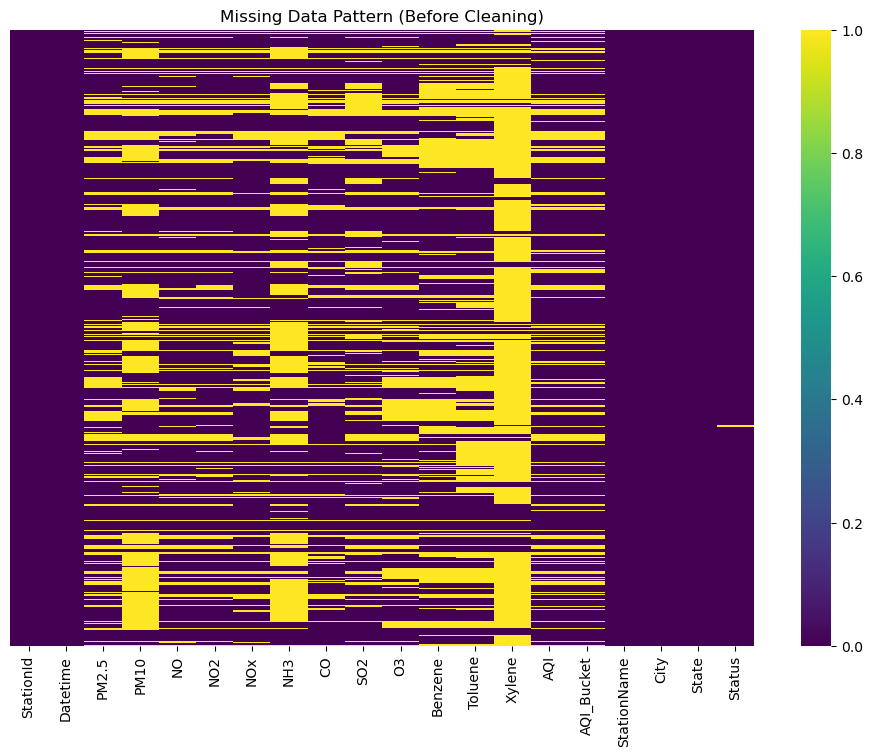

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_primary.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Data Pattern (Before Cleaning)')
plt.show()

**HeatMap Interpretation**

From this heatmap, it indicates Xylene has a huge proportion of missing values, seemingly over 50% and is considered for removal due to it's inclusion increasing the risk of introducing bias or instability if imputed. Features like NH3 and PM10 also have a huge amount of missing data, although not as extreme as Xylene. Other variables have non-trivial levels of missing values as well. It's appropriate to use more concrete percentage-based thresholds to determine what actions to take.

However, given just the pattern actions that will be considered will be: 
- Remove Variables with considerable missing values
- Apply imputation to the leftover numeric features using a method appropriate for skewed distributions.




In [37]:
missingPercentage = (df_primary.isnull().sum()/ len(df_primary)) * 100
missingPercentage

StationId       0.000000
Datetime        0.000000
PM2.5          25.016154
PM10           43.229669
NO             21.386375
NO2            20.430902
NOx            18.956828
NH3            47.762779
CO             19.284897
SO2            28.687261
O3             28.039773
Benzene        33.277380
Toluene        40.260046
Xylene         80.148222
AQI            22.022855
AQI_Bucket     22.022855
StationName     0.000000
City            0.000000
State           0.000000
Status          0.297634
dtype: float64

**Removing Feature**

In this case Xylene's inclusion in the model is only going to be a hinderence with 80% missing values, to prevent data leakage and maintain consistency in the datasets it will be removed before splitting. With that high of a proportion of missing data it is unlikely to provide useful information to our model.

In [103]:
# Remove Xylene from the dataset (Too many missing values)
df_whole = df_primary.drop(['Xylene'],axis=1)


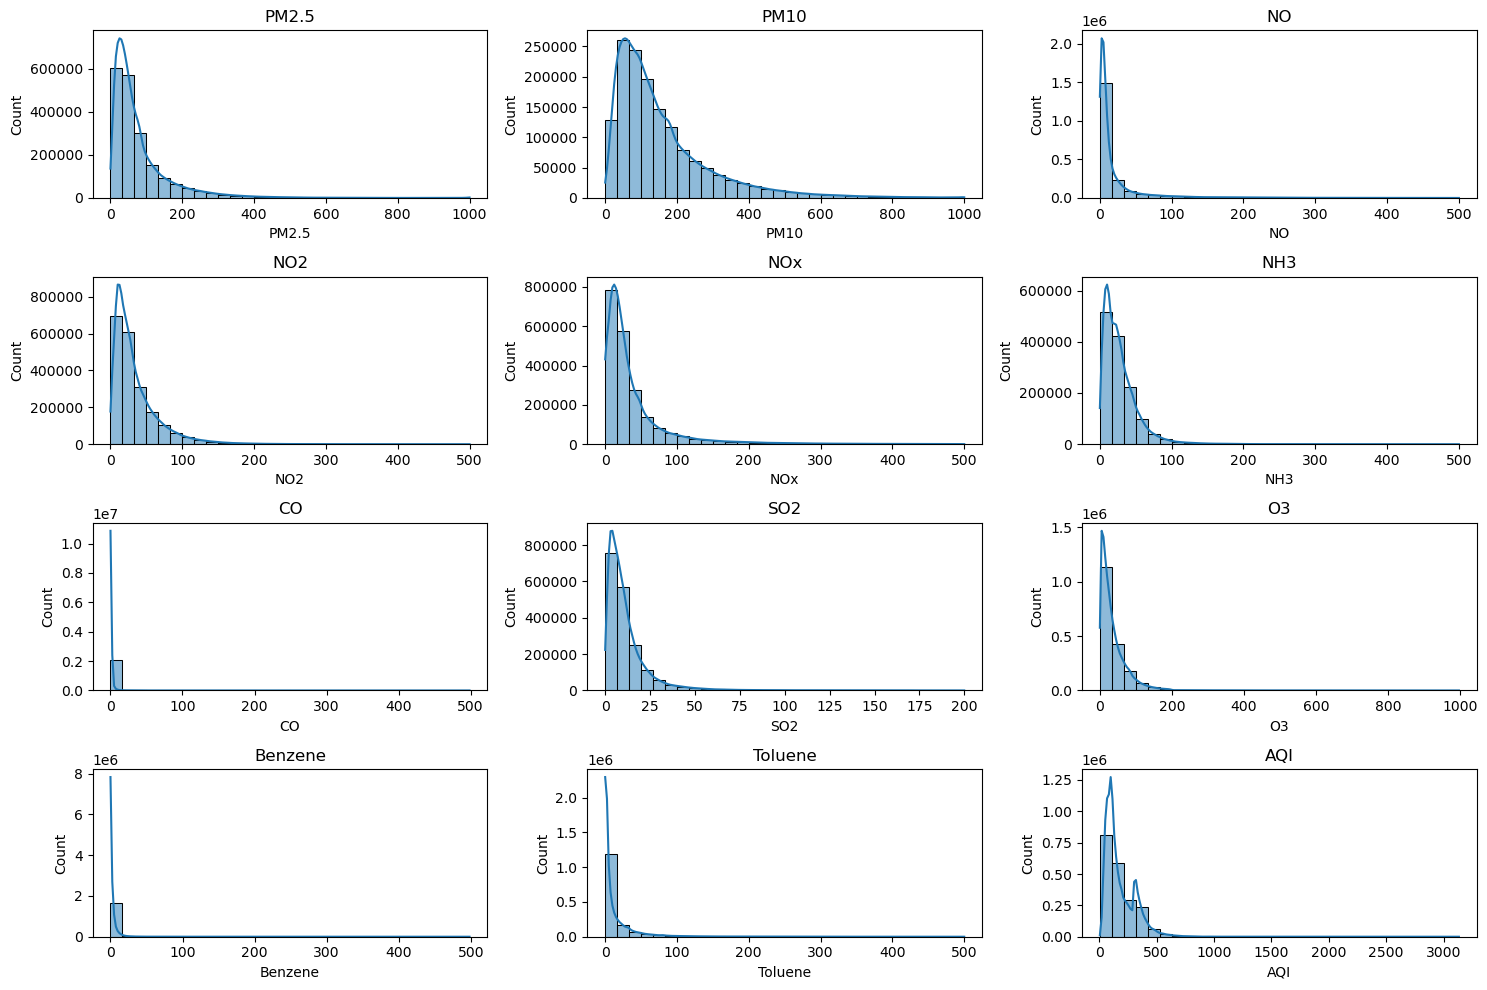

In [111]:
def plot_numeric_distributions(df, bins=30, figsize=(15, 10)):
    """
    Plots histograms for all numerical features in the dataframe.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col].dropna(), kde=True, bins=bins, ax=axes[i])
        axes[i].set_title(col)
    
    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_numeric_distributions(df_whole)

**Distribution Interpretation**

From these distributions, it is clear that every variable is highly right-skewed, indicating that some transformations should be made after splitting and cleaning the data further. This indicates the presence of outliers and long tails, which need to be accounted for. Certain ML models, such as linear regression and KNN, can be highly negatively affected by these undesirable characteristics. A log transformation will be considered to improve such skewness.

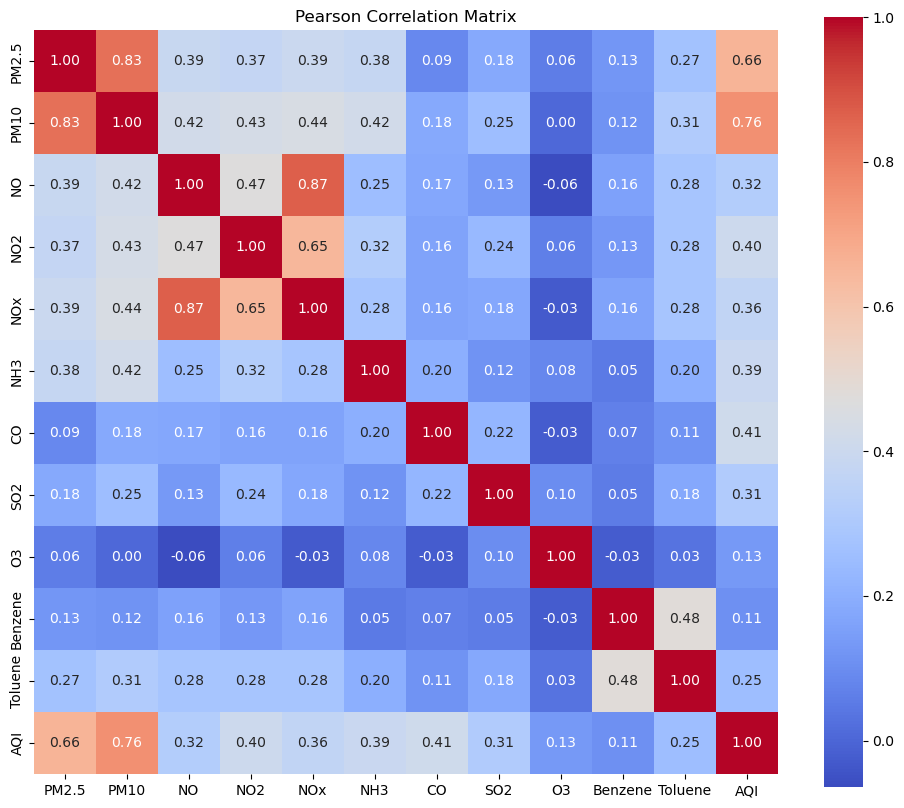

In [112]:
def plot_correlation_matrix(df, method='pearson', figsize=(12, 10)):
    """
    Plots a heatmap of the correlation matrix for numerical features.
    """
    numeric_df = df.select_dtypes(include=['number'])
    corr = numeric_df.corr(method=method)

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
    plt.title(f'{method.capitalize()} Correlation Matrix')
    plt.show()

plot_correlation_matrix(df_whole)

**Correlation Matrix Interpretation**

PM10 and PM2.5 have notably strong positive correlations with AQI (the numeric representation of the target variable AQI_Bucket). However, it should be noted that these two features are highly correlated with each other, meaning we need to be mindful of multi-collinearity hindering performance. Other problematic relationships between variables include NOx and NO2 as well as NOx and NO, which have a correlation coefficient of 0.87, which is very concerning. Considerations to avoid multicollinearity issues may have to be outright removing NOx or applying dimensionality reduction techniques such as PCA. 

In [104]:
#Split the dataset to avoid data leakage

from sklearn.model_selection import train_test_split


df_train, df_temp = train_test_split(df_whole, test_size=0.3, random_state=42)


df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)


print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")



Train shape: (1812358, 19)
Validation shape: (388362, 19)
Test shape: (388363, 19)


**Dealing with missing values**

In this case, we have quite a large amount of missing data; each feature has some missing values, which we'd expect from a dataset from a difficult recording environment, such as capturing the level of air pollution. The best approach to take in this case is to use standard median-based imputation for features that are missing <=10% of their entries. Then, for the remainder features with higher proportions of missing values, applying SimpleImputer imputation is the best approach to accommodate computation power without having to rely on multithreading alternatives for weaker devices, but still effective in capturing the essence of the missing data.

In [51]:
from sklearn.impute import SimpleImputer

def targetedImputation(df):
    """Fast imputation using SimpleImputer (median strategy)"""

    df_clean = df.copy()

    features_to_remove = ['Xylene']
    df_clean = df_clean.drop(columns=features_to_remove, errors='ignore')
    print(f"Removed features: {features_to_remove}")

    if 'Status' in df_clean.columns:
        mode_val = df_clean['Status'].mode()[0]
        df_clean['Status'].fillna(mode_val, inplace=True)
        print(f"Status imputed with mode: {mode_val}")

    # All pollutants to impute
    lower_missing = ['NOx', 'CO', 'NO2', 'NO']
    moderate_missing = ['PM2.5', 'SO2', 'O3', 'Benzene']
    higher_missing = ['Toluene', 'PM10', 'NH3']
    all_pollutants = lower_missing + moderate_missing + higher_missing

    available_pollutants = [f for f in all_pollutants if f in df_clean.columns]

    if available_pollutants:
        print(f"\nApplying SimpleImputer (median) to {len(available_pollutants)} pollutants...")
        imputer = SimpleImputer(strategy='median')
        before_missing = df_clean[available_pollutants].isnull().sum()
        df_clean[available_pollutants] = imputer.fit_transform(df_clean[available_pollutants])

        print("Imputation summary:")
        for feature in available_pollutants:
            pct_missing = (before_missing[feature] / len(df_clean)) * 100
            print(f"   {feature}: {before_missing[feature]:,} values ({pct_missing:.1f}%)")

    print(f"\nAQI and AQI_Bucket left untouched for complete case modeling")
    return df_clean

In [109]:
df_train_imputed = targetedImputation(df_train)


print(f"\nTRAINING SET STATUS:")
print(f"Shape: {df_train.shape}")
print(f"Features imputed: {(df_train.isnull().sum() == 0).sum() - 2}")  # -2 for AQI features
print(f"Ready for complete case modeling on AQI_Bucket")

Removed features: ['Xylene']
Status imputed with mode: Active

Applying SimpleImputer (median) to 11 pollutants...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14808\2393792596.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Status'].fillna(mode_val, inplace=True)


Imputation summary:
   NOx: 343,550 values (19.0%)
   CO: 349,537 values (19.3%)
   NO2: 370,259 values (20.4%)
   NO: 387,507 values (21.4%)
   PM2.5: 453,408 values (25.0%)
   SO2: 519,879 values (28.7%)
   O3: 507,896 values (28.0%)
   Benzene: 603,053 values (33.3%)
   Toluene: 729,676 values (40.3%)
   PM10: 783,034 values (43.2%)
   NH3: 865,407 values (47.8%)

AQI and AQI_Bucket left untouched for complete case modeling

TRAINING SET STATUS:
Shape: (1812358, 19)
Features imputed: 3
Ready for complete case modeling on AQI_Bucket


In [54]:
#Outlier Detection

def detect_outliers(df):
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'CO', 'SO2', 'O3', 'NH3', 'Benzene', 'Toluene']
    
    print("OUTLIER DETECTION:")
    print("=" * 50)
    
    for pollutant in pollutants:
        if pollutant in df.columns:
            Q1 = df[pollutant].quantile(0.25)
            Q3 = df[pollutant].quantile(0.75)
            IQR = Q3 - Q1
            
            # Outlier bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count outliers
            outliers = df[(df[pollutant] < lower_bound) | (df[pollutant] > upper_bound)]
            
            print(f"{pollutant}:")
            print(f"  Range: {df[pollutant].min():.2f} - {df[pollutant].max():.2f}")
            print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
            print(f"  Outlier bounds: <{lower_bound:.2f} or >{upper_bound:.2f}")
            
            # Check for impossible values (negative pollutants)
            negative_values = (df[pollutant] < 0).sum()
            if negative_values > 0:
                print(f" NEGATIVE VALUES: {negative_values}")




In [56]:
#Finding Duplicate Rows

def check_duplicates(df):
    # Check for exact duplicates
    exact_duplicates = df.duplicated().sum()
    print(f"Exact duplicates: {exact_duplicates}")
    
    # Check for duplicates based on station and time
    time_station_duplicates = df.duplicated(subset=['StationId', 'Datetime']).sum()
    print(f"Same station/time duplicates: {time_station_duplicates}")
    
    if time_station_duplicates > 0:
        print("Multiple readings for same station/time - investigate!")
        duplicated_rows = df[df.duplicated(subset=['StationId', 'Datetime'], keep=False)]
        print(duplicated_rows[['StationId', 'Datetime', 'PM2.5', 'AQI']].head())
    
    return exact_duplicates, time_station_duplicates



In [61]:
#Function Test on temp df
exact_dups, time_dups = check_duplicates(df_for_ml)

Exact duplicates: 0
Same station/time duplicates: 0


In [105]:
#Function to export a clean dataset for Inference research 

def create_datasets_for_different_analyses(df):
    """Create optimized datasets for ML vs Statistical Analysis"""
    
    df_base = df.copy()
    
    # Basic cleaning (same for both)
    print("BASIC CLEANING (both datasets)")
    print("=" * 40)
    
    # Remove negative values
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'CO', 'SO2', 'O3', 'NH3', 'Benzene', 'Toluene', 'NOx']
    
    for pollutant in pollutants:
        if pollutant in df_base.columns:
            before = len(df_base)
            df_base = df_base[df_base[pollutant] >= 0]
            removed = before - len(df_base)
            if removed > 0:
                print(f"{pollutant}: Removed {removed} negative values")
    
    #For ML Classification (Python)
    df_ml = df_base.dropna(subset=['AQI_Bucket']).copy()
    
    # Remove AQI to avoid multicollinearity in ML
    df_ml = df_ml.drop('AQI', axis=1, errors='ignore')
    
    print(f"\n ML DATASET (Classification):")
    print(f"Target: AQI_Bucket (categorical)")
    print(f"Shape: {df_ml.shape}")
    print(f"Classes: {df_ml['AQI_Bucket'].value_counts().index.tolist()}")
    
    # For Statistical Inference (R) 
    df_stats = df_base.dropna(subset=['AQI']).copy()
    
    # Remove AQI_Bucket for statistical analysis
    df_stats = df_stats.drop('AQI_Bucket', axis=1, errors='ignore')
    
    print(f"\n STATISTICAL DATASET (Regression/Inference):")
    print(f"Target: AQI (continuous)")  
    print(f"Shape: {df_stats.shape}")
    print(f"AQI range: {df_stats['AQI'].min():.1f} - {df_stats['AQI'].max():.1f}")
    print(f"AQI mean: {df_stats['AQI'].mean():.1f}")
    
    return df_ml, df_stats

# Create both datasets (only using stats df)
df_for_ml, df_for_stats = create_datasets_for_different_analyses(df_whole)

BASIC CLEANING (both datasets)
PM2.5: Removed 647689 negative values
PM10: Removed 571615 negative values
NO: Removed 70019 negative values
NO2: Removed 13811 negative values
CO: Removed 31216 negative values
SO2: Removed 191534 negative values
O3: Removed 28581 negative values
NH3: Removed 51279 negative values
Benzene: Removed 113627 negative values
Toluene: Removed 140352 negative values
NOx: Removed 5548 negative values

 ML DATASET (Classification):
Target: AQI_Bucket (categorical)
Shape: (707762, 18)
Classes: ['Moderate', 'Satisfactory', 'Very Poor', 'Poor', 'Good', 'Severe']

 STATISTICAL DATASET (Regression/Inference):
Target: AQI (continuous)
Shape: (707762, 18)
AQI range: 8.0 - 1057.0
AQI mean: 183.8


In [110]:
#Cleaning training model of impossible values

df_train_cleaned, df_stats_subset = create_datasets_for_different_analyses(df_train_imputed)

BASIC CLEANING (both datasets)

 ML DATASET (Classification):
Target: AQI_Bucket (categorical)
Shape: (1413523, 18)
Classes: ['Moderate', 'Satisfactory', 'Very Poor', 'Poor', 'Good', 'Severe']

 STATISTICAL DATASET (Regression/Inference):
Target: AQI (continuous)
Shape: (1413523, 18)
AQI range: 5.0 - 3133.0
AQI mean: 180.2


In [106]:
import os

# Confirm save directory exists
save_dir = os.path.join(os.getcwd(), 'data', 'processed')
os.makedirs(save_dir, exist_ok=True)

# Define full paths
ml_path = os.path.join(save_dir, 'air_quality_ml.csv')
stats_path = os.path.join(save_dir, 'air_quality_stats.csv')

# Save datasets
df_for_ml.to_csv(ml_path, index=False)
df_for_stats.to_csv(stats_path, index=False)


print(f" SAVED TWO DATASETS:")
print(f"ML (Python): {ml_path}")
print(f"  - Target: AQI_Bucket (classification)")
print(f"  - Shape: {df_for_ml.shape}")
print(f"  - Size: {os.path.getsize(ml_path) / (1024**2):.1f} MB")

print(f"\nStats (R): {stats_path}")
print(f"  - Target: AQI (continuous regression)")
print(f"  - Shape: {df_for_stats.shape}")
print(f"  - Size: {os.path.getsize(stats_path) / (1024**2):.1f} MB")


 SAVED TWO DATASETS:
ML (Python): C:\Users\Administrator\data\processed\air_quality_ml.csv
  - Target: AQI_Bucket (classification)
  - Shape: (707762, 18)
  - Size: 102.1 MB

Stats (R): C:\Users\Administrator\data\processed\air_quality_stats.csv
  - Target: AQI (continuous regression)
  - Shape: (707762, 18)
  - Size: 99.7 MB


**Feature Engineering**

To give the model the best information coenciding with hourly data, this function (create_time_features) will add basic time features, seasonal features, rush hour indicators and cyclical encoding so the model better understands the relationship of time.

In [93]:
# Create time-based features
def create_time_features(df):
    """Create essential time-based features for air quality prediction"""
    
    df = df.copy()
    
    # Basic time features
    df['hour'] = df['Datetime'].dt.hour
    df['day_of_week'] = df['Datetime'].dt.dayofweek
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    df['day_of_year'] = df['Datetime'].dt.dayofyear
    
    # Seasonal features
    df['season'] = df['month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring', 
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })
    
    # Rush hour indicators
    df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Cyclical encoding for hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Cyclical encoding for day of year (seasonal patterns)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    print("Created time-based features:")
    new_features = ['hour', 'day_of_week', 'month', 'season', 'is_rush_hour', 
                   'is_weekend', 'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos']
    print(f"   {new_features}")
    
    return df



In [96]:
# Test Case

ml_test_subset=df_for_ml.copy()
ml_test_subset['Datetime'] = pd.to_datetime(ml_test_subset['Datetime'])

In [97]:
#Testing Function
ml_test_subset = create_time_features(ml_test_subset)

Created time-based features:
   ['hour', 'day_of_week', 'month', 'season', 'is_rush_hour', 'is_weekend', 'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos']


In [98]:
# Verifying function works correctly
ml_test_subset.head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,month,year,day_of_year,season,is_rush_hour,is_weekend,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos
16,AP001,2017-11-25 09:00:00,104.00,148.50,1.93,23.00,13.75,9.80,0.1,15.30,...,11,2017,329,Fall,1,1,7.071068e-01,-0.707107,-0.5808,0.814046
17,AP001,2017-11-25 10:00:00,94.50,142.00,1.33,16.25,9.75,9.65,0.1,17.00,...,11,2017,329,Fall,0,1,5.000000e-01,-0.866025,-0.5808,0.814046
18,AP001,2017-11-25 11:00:00,82.75,126.50,1.47,14.83,9.07,9.70,0.1,15.40,...,11,2017,329,Fall,0,1,2.588190e-01,-0.965926,-0.5808,0.814046
19,AP001,2017-11-25 12:00:00,79.00,124.00,5.30,21.15,15.53,9.40,0.1,8.25,...,11,2017,329,Fall,0,1,1.224647e-16,-1.000000,-0.5808,0.814046
20,AP001,2017-11-25 13:00:00,52.59,116.25,7.15,24.79,22.86,22.35,0.8,8.25,...,11,2017,329,Fall,0,1,-2.588190e-01,-0.965926,-0.5808,0.814046


In [99]:
#Function for validating Engineered Feature

def validate_time_features(df):
    """Quick validation of time features"""
    
    print("TIME FEATURE VALIDATION")
    print("=" * 30)
    
    
    sample = df.head()
    
    for idx, row in sample.iterrows():
        dt = pd.to_datetime(row['Datetime'])
        
        print(f"\nRow {idx}: {dt}")
        print(f"  Expected vs Actual:")
        print(f"  Hour: {dt.hour} vs {row['hour']}")
        print(f"  Month: {dt.month} vs {row['month']}")
        print(f"  Day of week: {dt.dayofweek} vs {row.get('day_of_week', 'missing')}")
        print(f"  Is weekend: {dt.dayofweek >= 5} vs {row['is_weekend']}")
        print(f"  Is rush hour: {dt.hour in [7,8,9,17,18,19]} vs {row['is_rush_hour']}")
        
        # Check if weekend detection is correct
        if (dt.dayofweek >= 5) != row['is_weekend']:
            print(f" WARNING: Weekend detection mismatch!")


validate_time_features(ml_test_subset)

# Check completeness
print(f"\nOVERALL CHECK:")
print(f"Original shape: Unknown")
print(f"Current shape: {ml_test_subset.shape}")
print(f"New time features added: ~10")
print(f"Missing values in time features: {ml_test_subset[['hour', 'month', 'season', 'is_weekend']].isnull().sum().sum()}")

TIME FEATURE VALIDATION

Row 16: 2017-11-25 09:00:00
  Expected vs Actual:
  Hour: 9 vs 9
  Month: 11 vs 11
  Day of week: 5 vs 5
  Is weekend: True vs 1
  Is rush hour: True vs 1

Row 17: 2017-11-25 10:00:00
  Expected vs Actual:
  Hour: 10 vs 10
  Month: 11 vs 11
  Day of week: 5 vs 5
  Is weekend: True vs 1
  Is rush hour: False vs 0

Row 18: 2017-11-25 11:00:00
  Expected vs Actual:
  Hour: 11 vs 11
  Month: 11 vs 11
  Day of week: 5 vs 5
  Is weekend: True vs 1
  Is rush hour: False vs 0

Row 19: 2017-11-25 12:00:00
  Expected vs Actual:
  Hour: 12 vs 12
  Month: 11 vs 11
  Day of week: 5 vs 5
  Is weekend: True vs 1
  Is rush hour: False vs 0

Row 20: 2017-11-25 13:00:00
  Expected vs Actual:
  Hour: 13 vs 13
  Month: 11 vs 11
  Day of week: 5 vs 5
  Is weekend: True vs 1
  Is rush hour: False vs 0

OVERALL CHECK:
Original shape: Unknown
Current shape: (2018893, 30)
New time features added: ~10
Missing values in time features: 0


In [115]:
df_train_cleaned['Datetime'] = pd.to_datetime(df_train_cleaned['Datetime'])
df_train_cleaned = create_time_features(df_train_cleaned)

Created time-based features:
   ['hour', 'day_of_week', 'month', 'season', 'is_rush_hour', 'is_weekend', 'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos']


In [116]:
#Check Feature Engineering worked correctly on Working DF
validate_time_features(df_train_cleaned)

TIME FEATURE VALIDATION

Row 1385271: 2019-06-23 21:00:00
  Expected vs Actual:
  Hour: 21 vs 21
  Month: 6 vs 6
  Day of week: 6 vs 6
  Is weekend: True vs 1
  Is rush hour: False vs 0

Row 816537: 2019-08-23 11:00:00
  Expected vs Actual:
  Hour: 11 vs 11
  Month: 8 vs 8
  Day of week: 4 vs 4
  Is weekend: False vs 0
  Is rush hour: False vs 0

Row 868861: 2020-05-14 01:00:00
  Expected vs Actual:
  Hour: 1 vs 1
  Month: 5 vs 5
  Day of week: 3 vs 3
  Is weekend: False vs 0
  Is rush hour: False vs 0

Row 2521754: 2019-10-04 14:00:00
  Expected vs Actual:
  Hour: 14 vs 14
  Month: 10 vs 10
  Day of week: 4 vs 4
  Is weekend: False vs 0
  Is rush hour: False vs 0

Row 1798467: 2020-03-01 01:00:00
  Expected vs Actual:
  Hour: 1 vs 1
  Month: 3 vs 3
  Day of week: 6 vs 6
  Is weekend: True vs 1
  Is rush hour: False vs 0


In [113]:
#Checking for Duplicate Rows
exact_dups, time_dups = check_duplicates(df_train_cleaned)

Exact duplicates: 0
Same station/time duplicates: 0


In [60]:
#Checking for Outliers in numeric variables
detect_outliers(df_train_cleaned)

OUTLIER DETECTION:
PM2.5:
  Range: 0.01 - 1000.00
  Outliers: 292933 (11.31%)
  Outlier bounds: <-27.88 or >141.12
PM10:
  Range: 0.01 - 1000.00
  Outliers: 772622 (29.84%)
  Outlier bounds: <57.62 or >176.62
NO:
  Range: 0.01 - 500.00
  Outliers: 375117 (14.49%)
  Outlier bounds: <-10.15 or >27.29
NO2:
  Range: 0.01 - 499.99
  Outliers: 231294 (8.93%)
  Outlier bounds: <-18.10 or >71.98
CO:
  Range: 0.00 - 498.57
  Outliers: 226819 (8.76%)
  Outlier bounds: <-0.55 or >2.25
SO2:
  Range: 0.01 - 199.96
  Outliers: 276345 (10.67%)
  Outlier bounds: <-2.73 or >19.88
O3:
  Range: 0.01 - 997.00
  Outliers: 275243 (10.63%)
  Outlier bounds: <-16.75 or >69.86
NH3:
  Range: 0.01 - 499.97
  Outliers: 1126873 (43.52%)
  Outlier bounds: <18.29 or >26.45
Benzene:
  Range: 0.00 - 498.07
  Outliers: 340557 (13.15%)
  Outlier bounds: <-1.86 or >4.11
Toluene:
  Range: 0.00 - 499.99
  Outliers: 461564 (17.83%)
  Outlier bounds: <-3.52 or >11.20


**Applying Transformations**

We can see that PM10 and NH3 are extremely concerning, with a huge percentage of outliers. In addition, we need to consider that these variables are all strongly right-skewed a few relationships display multicollinear relationships. To combat this, we will apply log transformations to both PM10 and NH3, then ensure all negative values are treated as missing values (then impute the dataframe). Then the model will be winsorized so the model is not as sensitive to extreme values. Finally, we can consider PCA and evaluate how this model performs compared to outright removing a feature such as NOx or PM10, which are highly correlated with other variables.

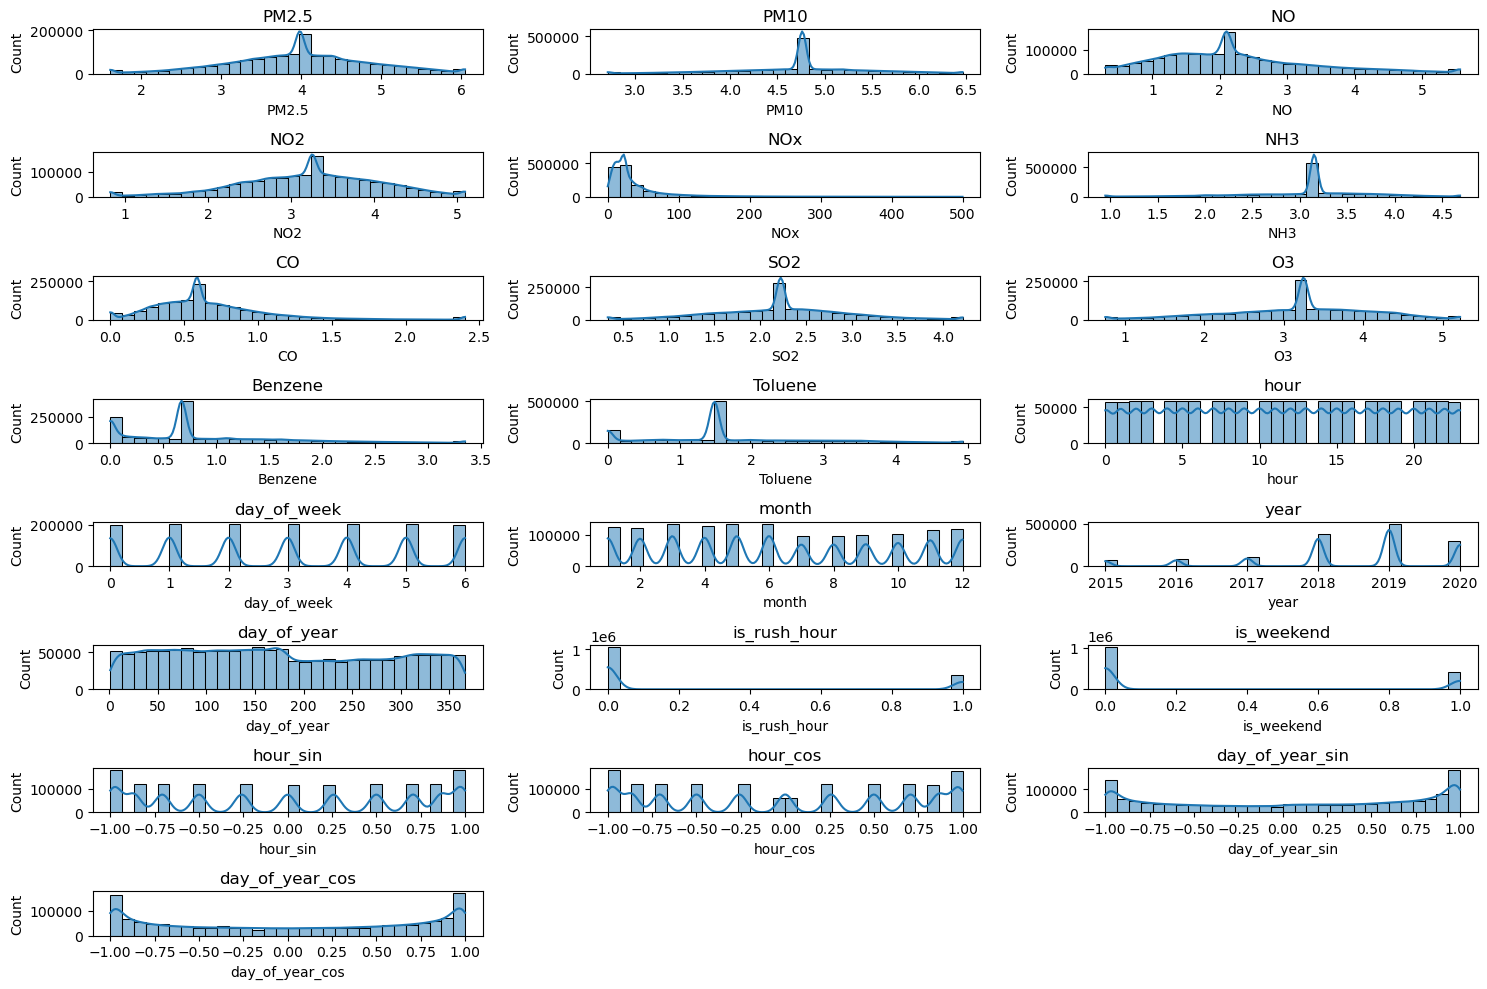

In [119]:
#Applying log transformations to the skewed numerical features

skewed_features = ['PM2.5', 'PM10', 'NO', 'NO2', 'CO', 'SO2', 'O3', 'NH3', 'Benzene', 'Toluene']
df_transformed = df_train_cleaned.copy()
df_transformed[skewed_features] = df_transformed[skewed_features].apply(lambda x: np.log1p(x))

for col in skewed_features:
    df_transformed[col] = df_transformed[col].apply(lambda x: np.nan if x < 0 else x)

#Apply winsorization to stop extreme model sensitivity (capping outliers)

def winsorize(df, features, lower=0.01, upper=0.99):
    df_winsorized = df.copy()
    for feature in features:
        lower_bound = df[feature].quantile(lower)
        upper_bound = df[feature].quantile(upper)
        df_winsorized[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
    return df_winsorized


df_winsorized = winsorize(df_transformed,skewed_features)
plot_numeric_distributions(df_winsorized)

**Transformation Evaluation**

We can see the transformation applied to the numeric features was extremely effective in combatting the highly right-skewed variables. This should increase the performance of the models, particularly models that are more sensitive to skewed data such as logistic regression.

In [120]:
detect_outliers(df_winsorized)

OUTLIER DETECTION:
PM2.5:
  Range: 1.61 - 6.05
  Outliers: 18346 (1.30%)
  Outlier bounds: <1.77 or >6.19
PM10:
  Range: 2.71 - 6.46
  Outliers: 141810 (10.03%)
  Outlier bounds: <3.51 or >6.03
NO:
  Range: 0.30 - 5.57
  Outliers: 38734 (2.74%)
  Outlier bounds: <-0.73 or >5.03
NO2:
  Range: 0.82 - 5.09
  Outliers: 19970 (1.41%)
  Outlier bounds: <1.01 or >5.48
CO:
  Range: 0.00 - 2.40
  Outliers: 67028 (4.74%)
  Outlier bounds: <-0.24 or >1.51
SO2:
  Range: 0.34 - 4.21
  Outliers: 48123 (3.40%)
  Outlier bounds: <0.48 or >3.95
O3:
  Range: 0.76 - 5.22
  Outliers: 17516 (1.24%)
  Outlier bounds: <0.83 or >5.60
NH3:
  Range: 0.95 - 4.69
  Outliers: 240786 (17.03%)
  Outlier bounds: <2.24 or >4.04
Benzene:
  Range: 0.00 - 3.35
  Outliers: 55982 (3.96%)
  Outlier bounds: <-1.02 or >2.56
Toluene:
  Range: 0.00 - 4.93
  Outliers: 72166 (5.11%)
  Outlier bounds: <-0.62 or >3.95


In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Encode AQI_Bucket as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_winsorized['AQI_Bucket'])
X = df_winsorized.drop(columns=['AQI_Bucket'])  # drop target and bucket

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

🔹 Model A – No PCA (Logistic Regression)
Accuracy: 0.5485
Macro F1 Score: 0.4669

Classification Report:
               precision    recall  f1-score   support

        Good       0.63      0.37      0.47     21039
    Moderate       0.54      0.72      0.62     94713
        Poor       0.39      0.07      0.12     33310
Satisfactory       0.57      0.58      0.57     74422
      Severe       0.61      0.34      0.43     16841
   Very Poor       0.54      0.65      0.59     42380

    accuracy                           0.55    282705
   macro avg       0.55      0.46      0.47    282705
weighted avg       0.54      0.55      0.52    282705



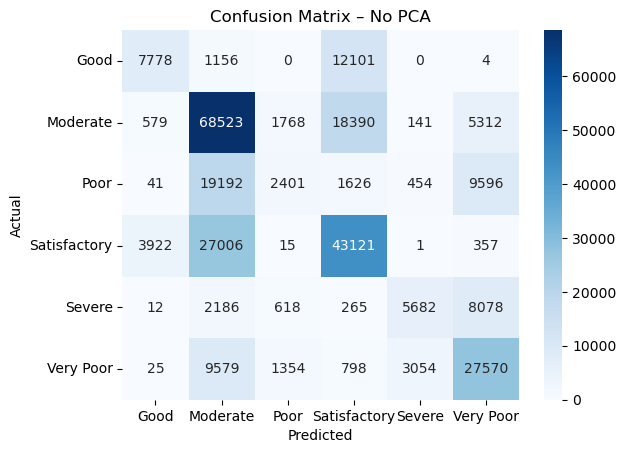

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include='number'))
X_test_scaled = scaler.transform(X_test.select_dtypes(include='number'))

# Train logistic regression without PCA
model_logreg = LogisticRegression(max_iter=1000)
model_logreg.fit(X_train_scaled, y_train)

# Predict
y_pred_logreg = model_logreg.predict(X_test_scaled)

# Evaluate
print("🔹 Model A – No PCA (Logistic Regression)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_logreg, average='macro'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – No PCA")
plt.show()

🔹 Model A – PCA Classification
Accuracy: 0.5378
Macro F1 Score: 0.4565

Classification Report:
               precision    recall  f1-score   support

        Good       0.63      0.37      0.46     21039
    Moderate       0.52      0.72      0.61     94713
        Poor       0.39      0.07      0.12     33310
Satisfactory       0.56      0.57      0.56     74422
      Severe       0.59      0.33      0.42     16841
   Very Poor       0.52      0.62      0.57     42380

    accuracy                           0.54    282705
   macro avg       0.54      0.44      0.46    282705
weighted avg       0.53      0.54      0.51    282705



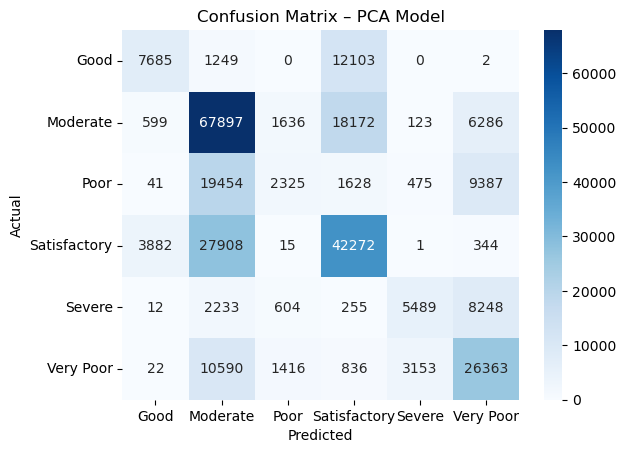

In [124]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include='number'))
X_test_scaled = scaler.transform(X_test.select_dtypes(include='number'))

# Apply PCA
pca = PCA(n_components=0.95)  # retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train classification model
model_pca = LogisticRegression(max_iter=1000)
model_pca.fit(X_train_pca, y_train)

# Predict
y_pred_pca = model_pca.predict(X_test_pca)

# Evaluate
print("🔹 Model A – PCA Classification")
print(f"Accuracy: {accuracy_score(y_test, y_pred_pca):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_pca, average='macro'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_pca, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – PCA Model")
plt.show()


🔹 Random Forest
Accuracy: 0.7962
Macro F1 Score: 0.7840

Classification Report:
               precision    recall  f1-score   support

        Good       0.85      0.75      0.80     21039
    Moderate       0.78      0.85      0.81     94713
        Poor       0.78      0.56      0.65     33310
Satisfactory       0.79      0.84      0.81     74422
      Severe       0.89      0.76      0.82     16841
   Very Poor       0.80      0.83      0.81     42380

    accuracy                           0.80    282705
   macro avg       0.81      0.76      0.78    282705
weighted avg       0.80      0.80      0.79    282705



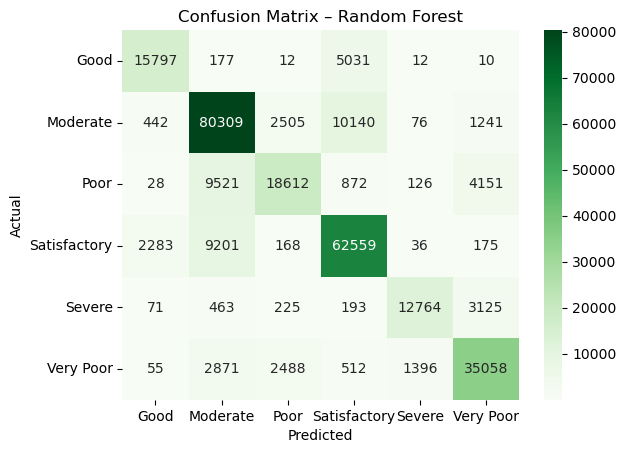

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include='number'))
X_test_scaled = scaler.transform(X_test.select_dtypes(include='number'))

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',  # handles imbalanced classes
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
print(" Random Forest")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()


**Model Selection / Evaluation**

To avoid allocating further computational resources, CV methods have been omitted to increase the reusability of this model. Categorical values have not been encoded as features, such as stationID, and stations don't have intrinsic predictive value. In addition, the model that has achieved the best performance with 80% accuracy on the test set is the RandomForest classifier, which is compatible with categorical features (without encoding). This classifier is also robust to multicollinearity, meaning the additional features could be kept in the model without worry about overlapping information present in each variable's coefficient (which would be an issue for classifiers like logistic regression). Both post-PCA logistic regression and base logistic regression models performed terribly on the test set (55% accuracy). XGBoost performed similarly to the logistic regression model with PCA and has been omitted for conciseness. The random forest classifier couldn't be run for such a large dataset in conjunction with Cross-Validation techniques without parallel threading. So the liberty of the best estimate for the hyperparameter approach has been taken, and achieved relatively good performance. 